## Boston bike rides duration prediction

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

### Load the datasets

In [2]:
# Please replace the path variable by the directory where the files will be stored.

path= 'C:\\Users\\krasi\\pyproj\\datasets\\Technical test 2023\\data\\'

weather_data= pd.read_csv(path + 'weather.csv')
hubway_trips= pd.read_csv(path + 'hubway_trips.csv')
hubway_stations= pd.read_csv(path + 'hubway_stations.csv')

In [3]:
weather_data.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 09:00,0.00,T,
1,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 10:00,0.00,T,
2,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 18:00,0.00,T,
3,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 21:00,0.03,,
4,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 22:00,0.04,,


In [4]:
hubway_trips.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


In [5]:
hubway_stations.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


### Data Cleaning

In [6]:
# Change the dates column into the datetime type, 
# this would allow us to merge weather and hubway trips tables based on date columns.

hubway_trips['start_date']= pd.to_datetime(hubway_trips['start_date'])
hubway_trips['end_date']= pd.to_datetime(hubway_trips['end_date'])
weather_data['DATE']= pd.to_datetime(weather_data['DATE'])

In [7]:
# Change the dates into the Hours period to allow merging the weather data into. 
# Additionally we need to subtract one hour from the weather DATE, because based on the documentation 
# this value at certain hour is accumulation from hour before - for example if we have a measurement 
# at time 10 pm it means this is the accumulation measure from 9 pm to 10 pm.

from datetime import timedelta

hubway_trips['DATE']= hubway_trips.start_date.dt.to_period("H")
weather_data['DATE']= weather_data.DATE.dt.to_period("H") - timedelta(hours=1)

# Merge the hubway trips and weather data together 
data= hubway_trips.merge(weather_data, how="left", on="DATE")

In [8]:
# Merge data table with hubway stations information, we will do this 2 times, both for
# staring station as well as end station

data= data.merge(hubway_stations, how="left", left_on="strt_statn", right_on="id")
data= data.merge(hubway_stations, how="left", left_on="end_statn", right_on="id")

data_copy=data.copy()

In [9]:
# We can drop columns with one unique value,
# these columns does not contain any information as the variance is 0 so we can drop them
# - they have no predictive power.

print(data.nunique())

#Drop the columns with one unique value

one_value_columns= data.columns[data.nunique()==1]
data.drop(one_value_columns, axis=1, inplace=True)

seq_id              1579025
hubway_id           1579025
status_x                  1
duration              15635
start_date           521432
strt_statn              142
end_date             515102
end_statn               142
bike_nr                1163
subsc_type                2
zip_code                530
birth_date               60
gender                    2
DATE                  14713
STATION                   1
STATION_NAME              1
ELEVATION                 1
LATITUDE                  1
LONGITUDE                 1
HPCP                     50
Measurement_Flag          3
Quality_Flag              1
id_x                    142
terminal_x              131
station_x               137
municipal_x               4
lat_x                   142
lng_x                   142
status_y                  2
id_y                    142
terminal_y              131
station_y               137
municipal_y               4
lat_y                   142
lng_y                   142
status              

In [10]:
data.sample(2)

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,...,lat_x,lng_x,status_y,id_y,terminal_y,station_y,municipal_y,lat_y,lng_y,status
1311882,1311883,1464222,1140,2013-09-19 14:33:00,98.0,2013-09-19 14:52:00,58.0,B00441,Casual,NaN,...,42.371848,-71.060292,Existing,58.0,D32017,The Esplanade - Beacon St. at Arlington St.,Boston,42.355596,-71.072780,Existing
1452796,1452797,1614792,1680,2013-10-19 12:58:00,80.0,2013-10-19 13:26:00,74.0,T01419,Casual,NaN,...,42.362429,-71.090188,Existing,74.0,M32018,Harvard Square at Mass Ave/ Dunster,Cambridge,42.373268,-71.118579,Existing


In [11]:
data.columns

Index(['seq_id', 'hubway_id', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender', 'DATE', 'HPCP', 'Measurement_Flag', 'id_x',
       'terminal_x', 'station_x', 'municipal_x', 'lat_x', 'lng_x', 'status_y',
       'id_y', 'terminal_y', 'station_y', 'municipal_y', 'lat_y', 'lng_y',
       'status'],
      dtype='object')

In [12]:
# Rename _x and _y columns for _start and _end respectively

data.columns = ['seq_id', 'hubway_id', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender', 'DATE', 'HPCP', 'Measurement_Flag', 'id_start',
       'terminal_start', 'station_start', 'municipal_start', 'lat_start', 'lng_start', 'status_start',
       'id_end', 'terminal_end', 'station_end', 'municipal_end', 'lat_end', 'lng_end',
       'status_end']

## Start Date features extract

In [13]:
# I will extract month, day of week, hour as this time features can have an impact on the duration

data['month']= data['start_date'].dt.month
data['day_of_week']= data['start_date'].dt.dayofweek
data['hour']= data['start_date'].dt.hour
data['weekend']= np.nan
data.loc[data['day_of_week']<=4,'weekend'] = 0
data.loc[data['day_of_week']>4,'weekend'] = 1
data['weekend']=data['weekend'].astype(int)

In [14]:
# We will extract first letter from the terminal start-
# we will see if it contains some predicting power after

data['terminal_letter_start'] = data['terminal_start'].apply(lambda x: str(x)[0])

In [15]:
data.terminal_letter_start.value_counts()

D    499409
B    328197
M    296778
C    197082
A    195475
S     39674
K     20603
E      1793
n        14
Name: terminal_letter_start, dtype: int64

## Zip code based features 

In [16]:
# We will import dataset with lat long and addresses scraped from web using geopy.
# This will help us to calculate approximate distance from the starting station to where the person is living.
# We can check if the person is from outside of Boston, outside Massachusets etc.
# The scraping code you can find in Zip_codes_info_scraping notebook

zip_codes= pd.read_csv('C:\\Users\\krasi\\pyproj\\Boston_bike_rides_duration\\Boston_zip_codes_info.csv')
zip_codes.drop('Unnamed: 0',axis=1, inplace=True)

In [17]:
zip_codes.sample(10)

,zip_code,address,home_lat,home_long
413,'02319,"United States, Via Provinciale Ovest, Mola, Po...",42.762896,10.395024
234,'01520,"Holden, Worcester County, Massachusetts, 01520...",42.344639,-71.850419
428,'03909,"York, York County, Maine, 03909, United States",43.159114,-70.642978
109,'01178,"United States, Via Provinciale Ovest, Mola, Po...",42.762896,10.395024
15,'02143,"Somerville, Middlesex County, Massachusetts, 0...",42.383327,-71.101313
462,'23103,"Goochland County, Virginia, 23103, United States",37.649648,-77.714118
461,'23456,"Virginia Beach, Virginia, 23456, United States",36.755216,-76.064538
218,'06418,"Derby, Naugatuck Valley Planning Region, Conne...",41.323629,-73.079570
181,'02045,"Hull, Plymouth County, Massachusetts, 02045, U...",42.301536,-70.904367
316,'01534,"Northbridge, Worcester County, Massachusetts, ...",42.137374,-71.646948


In [18]:
zip_codes.drop('address', axis=1, inplace=True)

In [19]:
# We will merge zip_codes info with our main data table
data= data.merge(zip_codes, how="left", left_on="zip_code", right_on="zip_code")

In [20]:
data.sample(10)

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,...,lat_end,lng_end,status_end,month,day_of_week,hour,weekend,terminal_letter_start,home_lat,home_long
1020740,1020741,1151569,660,2013-07-18 11:33:00,20.0,2013-07-18 11:44:00,24.0,T01308,Registered,'02124,...,42.351821,-71.045461,Existing,7,3,11,0,B,42.286935,-71.065810
299620,299621,341256,901,2012-06-26 13:12:00,23.0,2012-06-26 13:27:00,36.0,B00387,Registered,'01760,...,42.349673,-71.077303,Existing,6,1,13,0,B,42.297881,-71.352662
767757,767758,870235,960,2013-05-10 12:36:00,111.0,2013-05-10 12:52:00,98.0,T01317,Casual,NaN,...,42.371848,-71.060292,Existing,5,4,12,0,D,NaN,NaN
1333840,1333841,1487792,720,2013-09-24 07:47:00,39.0,2013-09-24 07:59:00,48.0,B00140,Registered,'02118,...,42.356755,-71.055407,Existing,9,1,7,0,C,42.339860,-71.068954
724557,724558,820554,420,2013-04-26 17:29:00,47.0,2013-04-26 17:36:00,22.0,B00332,Registered,'02043,...,42.352175,-71.055547,Existing,4,4,17,0,D,42.216836,-70.903023
1140145,1140146,1280699,300,2013-08-14 09:31:00,67.0,2013-08-14 09:36:00,128.0,B00319,Registered,'02139,...,42.362457,-71.084970,Existing,8,2,9,0,M,42.363958,-71.101662
700743,700744,792856,240,2013-04-16 16:39:00,21.0,2013-04-16 16:43:00,46.0,B00526,Registered,'02115,...,42.343864,-71.085918,Existing,4,1,16,0,C,42.346895,-71.089862
1191210,1191211,1335447,1680,2013-08-24 13:07:00,67.0,2013-08-24 13:35:00,33.0,T01449,Casual,NaN,...,42.349046,-71.096831,Existing,8,5,13,1,M,NaN,NaN
22790,22791,25184,711,2011-08-18 21:07:00,5.0,2011-08-18 21:19:00,46.0,B00091,Registered,'02115,...,42.343864,-71.085918,Existing,8,3,21,0,B,42.346895,-71.089862
1230711,1230712,1377476,0,2013-09-02 13:37:00,78.0,2013-09-02 13:37:00,78.0,B01467,Registered,'02144,...,42.379637,-71.095319,Existing,9,0,13,0,S,42.397094,-71.119030


In [21]:
data['home_distance']= np.sqrt(((data['lat_start']- data['home_lat'])**2) + ((data['lng_start']- data['home_long'])**2))

In [22]:
data[['lat_start', 'lng_start', 'home_lat', 'home_long', 'home_distance', 'duration']]

,lat_start,lng_start,home_lat,home_long,home_distance,duration
0,42.359677,-71.059364,45.572415,-122.685980,51.726485,9
1,42.359677,-71.059364,42.348072,-71.102231,0.044410,220
2,42.359677,-71.059364,42.357587,-71.065927,0.006887,56
3,42.359677,-71.059364,42.351139,-71.076505,0.019149,64
4,42.359677,-71.059364,45.514218,-122.638583,51.675593,12
...,...,...,...,...,...,...
1579020,42.376369,-71.114025,42.371329,-71.082967,0.031465,720
1579021,42.358100,-71.093198,42.383327,-71.101313,0.026500,480
1579022,42.387995,-71.119084,NaN,NaN,NaN,540
1579023,42.366426,-71.105495,42.371329,-71.082967,0.023056,120


In [23]:
data['log_home_distance']=np.log(data['home_distance'])

<Axes: xlabel='log_home_distance', ylabel='Density'>

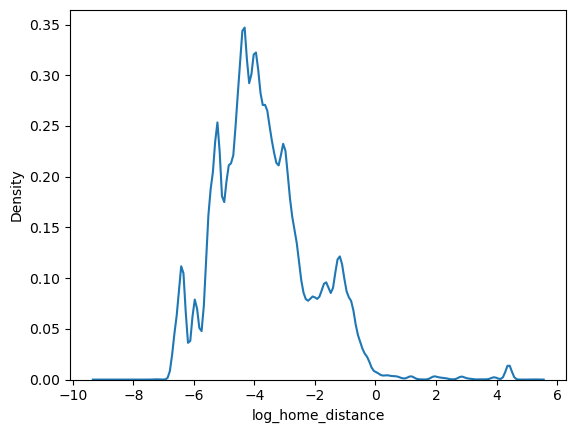

In [24]:
sns.kdeplot(data=data, x='log_home_distance')

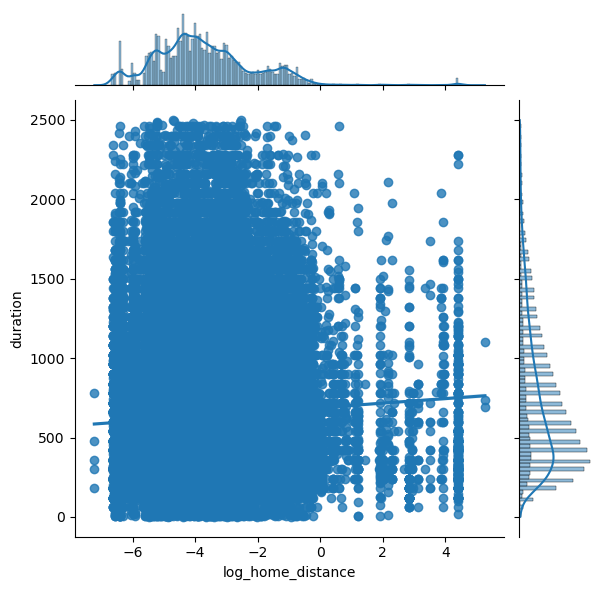

In [25]:
sns.jointplot(data=data[(data.duration<2500) & (data.duration>0)].sample(frac=0.1), x='log_home_distance', y='duration', kind='reg')

In [26]:
# Now as we have all the data merged together we can start to clean up the data.
# We can get rid of some duplicate columns and unique id columns, these will 
# be not good predictive features

data.drop(['seq_id', 'hubway_id', 'id_start', 'id_end', 'zip_code', 'end_date',
           'station_start', 'station_end', 'municipal_end', 'municipal_start', 'status_start',
          'status_end'],axis=1, inplace=True)

In [27]:
data.iloc[:5,:15]

,duration,start_date,strt_statn,end_statn,bike_nr,subsc_type,birth_date,gender,DATE,HPCP,Measurement_Flag,terminal_start,lat_start,lng_start,terminal_end
0,9,2011-07-28 10:12:00,23.0,23.0,B00468,Registered,1976.0,Male,2011-07-28 10:00,NaN,NaN,B32008,42.359677,-71.059364,B32008
1,220,2011-07-28 10:21:00,23.0,23.0,B00554,Registered,1966.0,Male,2011-07-28 10:00,NaN,NaN,B32008,42.359677,-71.059364,B32008
2,56,2011-07-28 10:33:00,23.0,23.0,B00456,Registered,1943.0,Male,2011-07-28 10:00,NaN,NaN,B32008,42.359677,-71.059364,B32008
3,64,2011-07-28 10:35:00,23.0,23.0,B00554,Registered,1981.0,Female,2011-07-28 10:00,NaN,NaN,B32008,42.359677,-71.059364,B32008
4,12,2011-07-28 10:37:00,23.0,23.0,B00554,Registered,1983.0,Female,2011-07-28 10:00,NaN,NaN,B32008,42.359677,-71.059364,B32008


In [28]:
data.iloc[:5,15:]

,lat_end,lng_end,month,day_of_week,hour,weekend,terminal_letter_start,home_lat,home_long,home_distance,log_home_distance
0,42.359677,-71.059364,7,3,10,0,B,45.572415,-122.685980,51.726485,3.945970
1,42.359677,-71.059364,7,3,10,0,B,42.348072,-71.102231,0.044410,-3.114288
2,42.359677,-71.059364,7,3,10,0,B,42.357587,-71.065927,0.006887,-4.978050
3,42.359677,-71.059364,7,3,10,0,B,42.351139,-71.076505,0.019149,-3.955497
4,42.359677,-71.059364,7,3,10,0,B,45.514218,-122.638583,51.675593,3.944986


#### Checking missing values

In [29]:
data.isna().sum()

duration                       0
start_date                     0
strt_statn                    14
end_statn                     45
bike_nr                      466
subsc_type                     0
birth_date               1228381
gender                    472611
DATE                           0
HPCP                     1485871
Measurement_Flag         1485871
terminal_start                14
lat_start                     14
lng_start                     14
terminal_end                  45
lat_end                       45
lng_end                       45
month                          0
day_of_week                    0
hour                           0
weekend                        0
terminal_letter_start          0
home_lat                  472766
home_long                 472766
home_distance             472780
log_home_distance         472780
dtype: int64

#### We see in the above that there are couple missing values in some columns, we can drop the rows where they are missing, it will not impact the model performance as these rows are very small subset of our data, we will drop the rows where status_end, status_start or bike_nr is NA value.

In [30]:
data.dropna(axis=0, subset=['strt_statn', 'end_statn', 'bike_nr'], inplace=True)

In [31]:
# We are left with four columns to clean up 

data.isna().sum()

duration                       0
start_date                     0
strt_statn                     0
end_statn                      0
bike_nr                        0
subsc_type                     0
birth_date               1228105
gender                    472341
DATE                           0
HPCP                     1485392
Measurement_Flag         1485392
terminal_start                 0
lat_start                      0
lng_start                      0
terminal_end                   0
lat_end                        0
lng_end                        0
month                          0
day_of_week                    0
hour                           0
weekend                        0
terminal_letter_start          0
home_lat                  472496
home_long                 472496
home_distance             472496
log_home_distance         472496
dtype: int64

In [32]:
# For the HPCP  we will fill 0 in the precipitation measure as based on documentation 
# hours with no precipitation are not shown.

data['HPCP']= data['HPCP'].fillna(0)

In [33]:
# Let's check how many unique values we have in the measurement flag column

data.Measurement_Flag.value_counts()

T    56362
     36468
g      286
Name: Measurement_Flag, dtype: int64

In [34]:
# We will create another column 'Rain' 
# from the HPCP column to indcate whether it was raining or not during the bike trip

data['Rain'] = data['HPCP'].apply(lambda x: x>0).astype(int)

# T value is indicating trace precipitation less than 0.01. We will feed Rain column with that info
# assigning value 1 wherever there is a T flag in a row.

data.loc[data.Measurement_Flag=='T', 'Rain'] = 1

In [35]:
# Now we can drop the column Measurement flag as info about that is in the HPCP column.

data.drop(['Measurement_Flag'], axis=1, inplace=True)

In [36]:
#For gender column we will fill NA values by "Unknown" string, I don't want to drop this column as 
# it can be a good predictor

data['gender']= data['gender'].fillna("Unknown")

In [37]:
data.isna().sum()

duration                       0
start_date                     0
strt_statn                     0
end_statn                      0
bike_nr                        0
subsc_type                     0
birth_date               1228105
gender                         0
DATE                           0
HPCP                           0
terminal_start                 0
lat_start                      0
lng_start                      0
terminal_end                   0
lat_end                        0
lng_end                        0
month                          0
day_of_week                    0
hour                           0
weekend                        0
terminal_letter_start          0
home_lat                  472496
home_long                 472496
home_distance             472496
log_home_distance         472496
Rain                           0
dtype: int64

In [38]:
# We will create age feature from birth_date

data['year']= data['start_date'].dt.year.astype(int)
data['age']= data['year'] - data['birth_date']
data[['year', 'birth_date', 'age']]

,year,birth_date,age
0,2011,1976.0,35.0
1,2011,1966.0,45.0
2,2011,1943.0,68.0
3,2011,1981.0,30.0
4,2011,1983.0,28.0
...,...,...,...
1579020,2013,NaN,NaN
1579021,2013,NaN,NaN
1579022,2013,NaN,NaN
1579023,2013,NaN,NaN


<Axes: xlabel='age', ylabel='duration'>

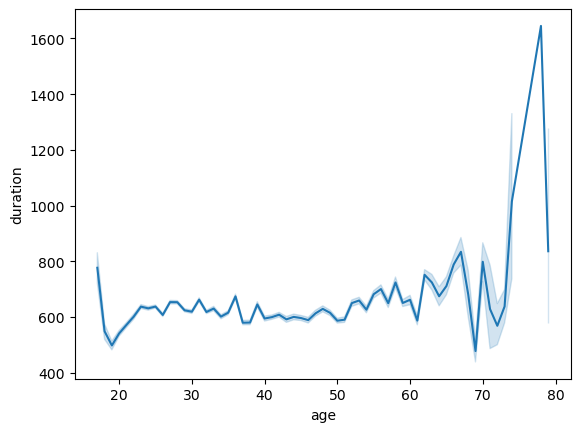

In [39]:
sns.lineplot(data=data[data.duration<2500], x='age', y='duration')

In [40]:
# We will create age category feature 
data['age_cat']= pd.qcut(data.age, 6)


In [41]:
data.age_cat.value_counts()

(25.0, 29.0]      69941
(16.999, 25.0]    63871
(32.0, 39.0]      63371
(48.0, 79.0]      55670
(39.0, 48.0]      54724
(29.0, 32.0]      42826
Name: age_cat, dtype: int64

In [42]:
# We create a feature that will derive the first letter from the Bike number, 
# we will then see what predictive power it will have

data['bike_id']= data.bike_nr.apply(lambda x: str(x)[0])

In [43]:
# We will create another column to check if person is subscribed or not

def registered(x):
    if x=='Registered':
        return 1
    else:
        return 0

data['subscription'] = data['subsc_type'].apply(registered)

In [44]:
# Change below two columns into categorical type
cat_cols=['strt_statn','terminal_letter_start','month', 'hour', 'day_of_week']

for col in cat_cols:
    pd.Categorical(data[col])

In [45]:
data['terminal_letter_start']= data['terminal_letter_start'].astype('category')

In [46]:
# We can drop columns that we don't need anymore

data.drop(['bike_nr', 'subsc_type', 'lat_start', 'home_lat', 'home_long',
           'lng_start', 'lat_end', 'lng_end', 'terminal_end', 'end_statn',
           'terminal_start', 'HPCP', 'year', 'age', 'birth_date', 'start_date', 'DATE'], axis=1, inplace=True)

In [47]:
data.sample(5)

,duration,strt_statn,gender,month,day_of_week,hour,weekend,terminal_letter_start,home_distance,log_home_distance,Rain,age_cat,bike_id,subscription
762032,180,24.0,Male,5,2,9,0,B,0.012336,-4.395238,0,NaN,B,1
488386,1477,42.0,Unknown,9,6,20,1,D,NaN,NaN,0,NaN,B,0
100998,298,48.0,Female,10,0,14,0,D,0.005806,-5.148811,0,"(25.0, 29.0]",B,1
1228848,540,113.0,Male,9,6,19,1,D,0.023461,-3.752400,0,NaN,T,1
25517,2079,20.0,Unknown,8,5,20,1,B,NaN,NaN,0,NaN,B,0


In [48]:
data['log_home_distance']= pd.cut(data.log_home_distance, 10)

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['age_cat'] = le.fit_transform(data['age_cat'])
data['terminal_letter_start'] = le.fit_transform(data['terminal_letter_start'])
data['log_home_distance'] = le.fit_transform(data['log_home_distance'])

In [50]:
data.head()

,duration,strt_statn,gender,month,day_of_week,hour,weekend,terminal_letter_start,home_distance,log_home_distance,Rain,age_cat,bike_id,subscription
0,9,23.0,Male,7,3,10,0,1,51.726485,9,0,3,B,1
1,220,23.0,Male,7,3,10,0,1,0.044410,4,0,4,B,1
2,56,23.0,Male,7,3,10,0,1,0.006887,2,0,5,B,1
3,64,23.0,Female,7,3,10,0,1,0.019149,3,0,2,B,1
4,12,23.0,Female,7,3,10,0,1,51.675593,9,0,1,B,1


## Exploratory Data Analysis

In [51]:
# Check the target skewness

print(data.duration.median())
print(data.duration.mean())

# Lets get rid of outliers from the duration column that have duration more than 2500.
# Also there are some rows where duration are below zero, we will drop those rows as well

data.drop(data[(data.duration>2500) | (data.duration<0)].index, axis=0, inplace=True)

660.0
1149.2912839212725


<Axes: xlabel='duration', ylabel='Density'>

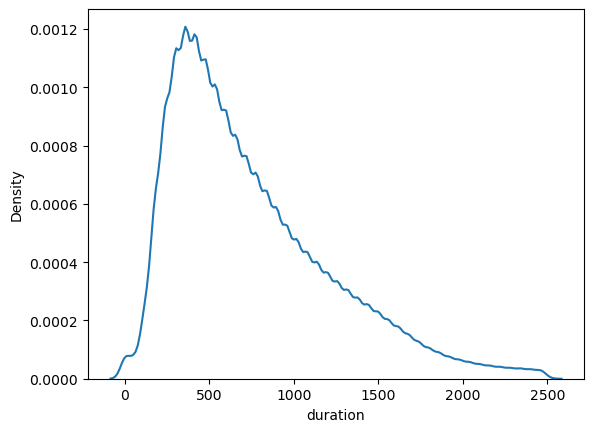

In [52]:
# We see below that the data is skewed but less than before.

sns.kdeplot(data=data, x='duration')

<Axes: xlabel='age_cat', ylabel='duration'>

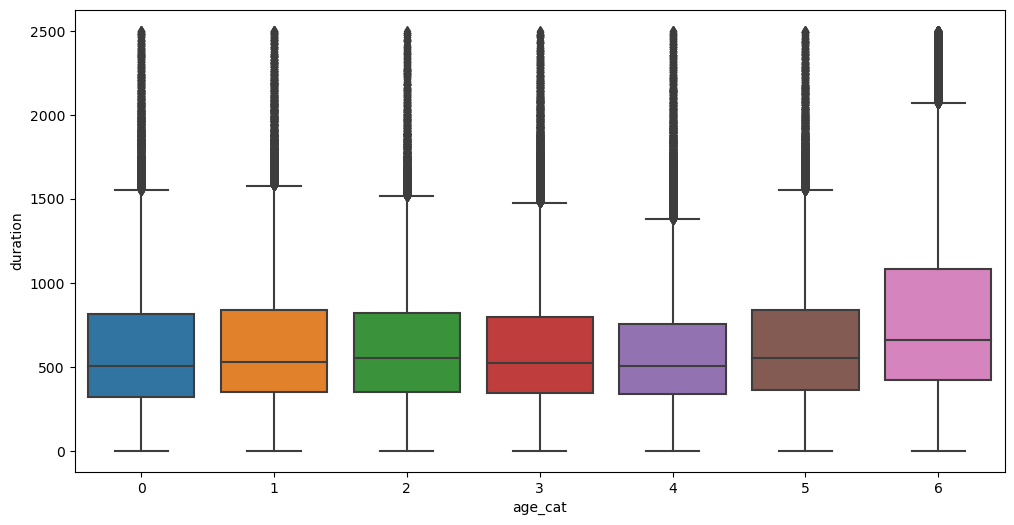

In [53]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=data, x='age_cat', y='duration')

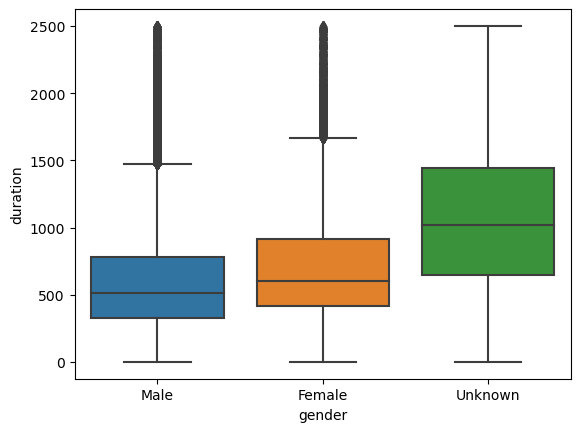

In [54]:
# Lets see the predictive power of our features - 
# the gender column seems to have an impact on the duration, let's create two hot one columns from the gender

sns.boxplot(x='gender', y='duration', data=data)

data= pd.get_dummies(data, columns=['gender'], drop_first=True)

<Axes: xlabel='month', ylabel='duration'>

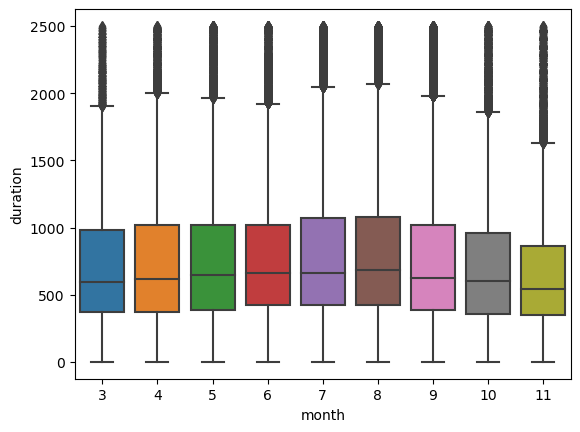

In [55]:
# Lets see the predictive power of our features - 
# the gender column seems to have an impact on the duration, let's create two hot one columns from the gender

sns.boxplot(x='month', y='duration', data=data)

<Axes: xlabel='weekend', ylabel='duration'>

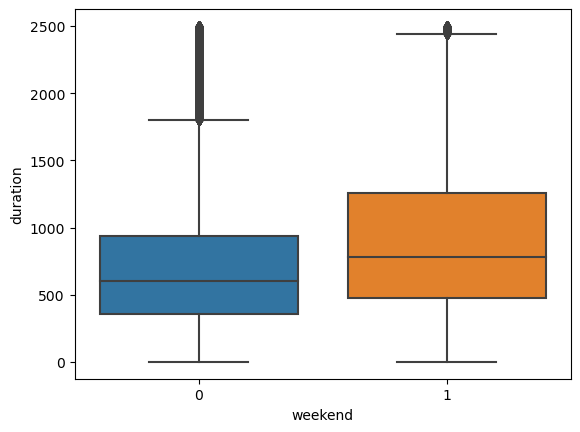

In [56]:
# Lets see the predictive power of our features - 
# the gender column seems to have an impact on the duration, let's create two hot one columns from the gender

sns.boxplot(x='weekend', y='duration', data=data)

<Axes: xlabel='hour', ylabel='duration'>

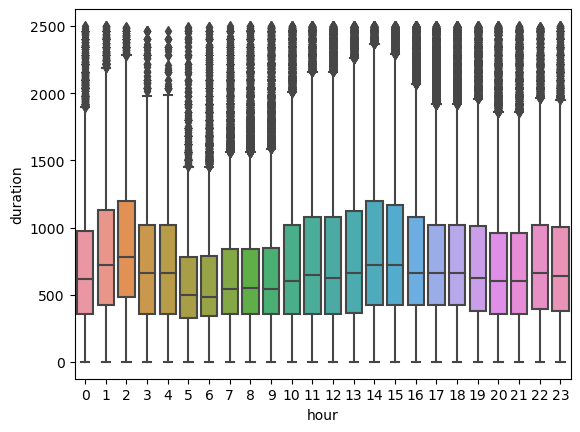

In [57]:
sns.boxplot(x='hour', y='duration',data=data)

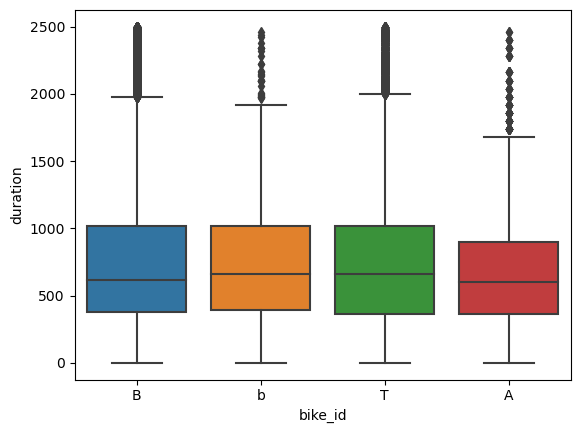

In [58]:
# We can drop bike_id as all groups have proportional means and variances in the durations outcome. 
sns.boxplot(x='bike_id', y='duration', data=data)

data.drop('bike_id', axis=1, inplace=True)

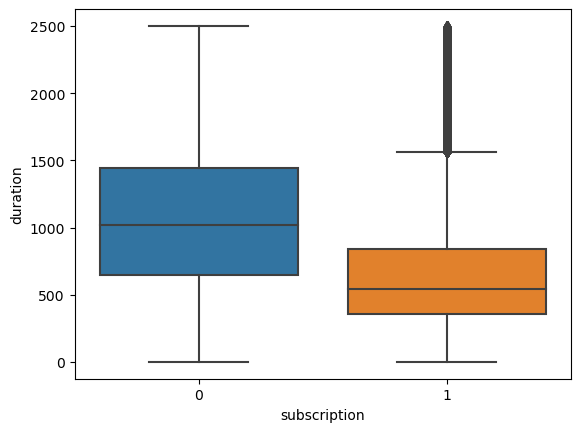

In [59]:
# The subscription feature is good predictor of 
# duration as we see that the two groups differs signifcantly from each other

sns.boxplot(x='subscription', y='duration', data=data)

# Nevertheless we will drop the subscription column because the info about subscription is in the gender column
# already - every person that is subscribed is labeled either Male or female in Gender, all the Unknown record are also
# unsubscribed.

data.drop('subscription',axis=1, inplace=True)

<Axes: xlabel='Rain', ylabel='duration'>

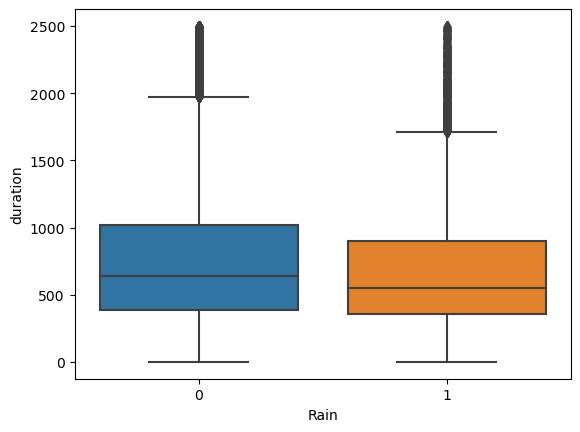

In [60]:
# It does not seem that rain is a factor in predicting the duration of a trip

sns.boxplot(data=data, x='Rain',  y='duration')

<Axes: xlabel='terminal_letter_start', ylabel='duration'>

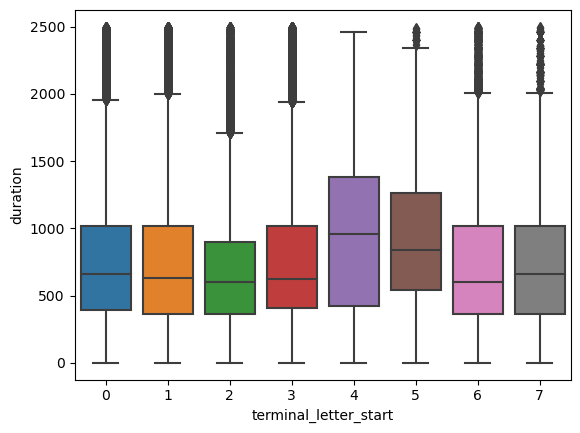

In [61]:
sns.boxplot(data=data, x='terminal_letter_start', y='duration')

<Axes: >

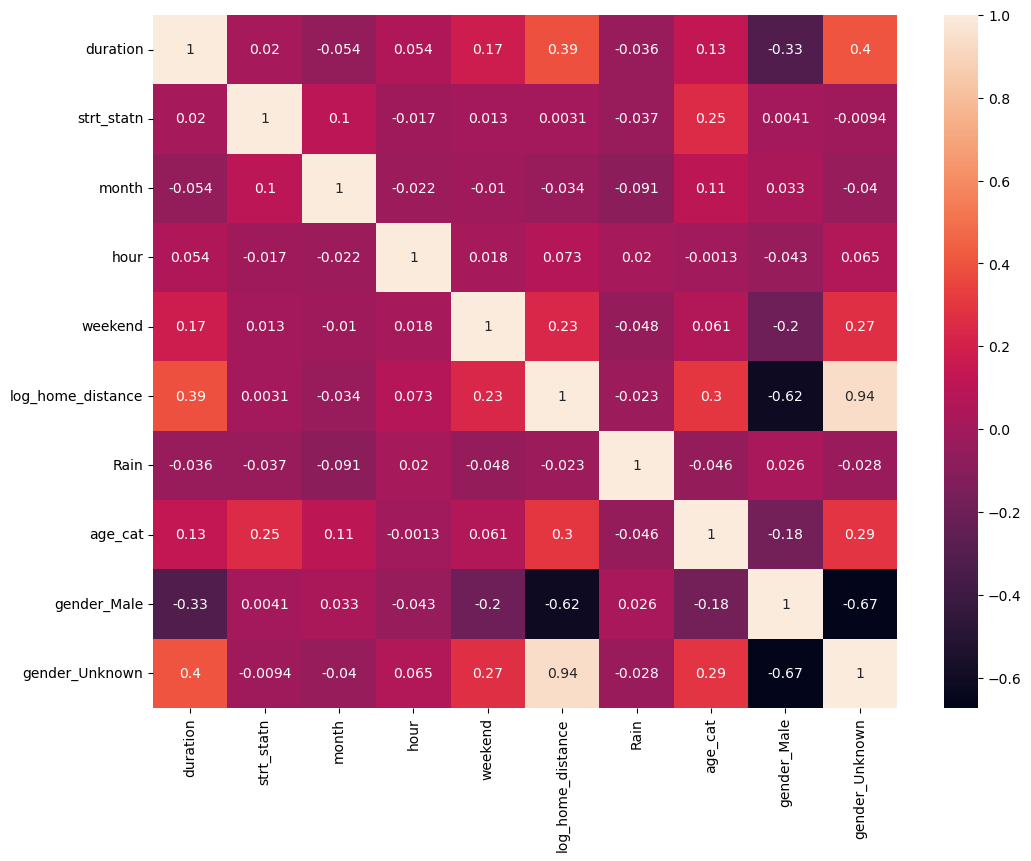

In [75]:
# We can also look at correlation matrix to check which features are highly correlated with duration

corr= data.corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, annot=True)

In [63]:
# Lastly we will drop day_of_week and terminal_letter start column as they are
# highly correlated with another feature weekend column

data.drop(['day_of_week', 'terminal_letter_start', 'home_distance'], axis=1, inplace=True)

In [64]:
data.head()

,duration,strt_statn,month,hour,weekend,log_home_distance,Rain,age_cat,gender_Male,gender_Unknown
0,9,23.0,7,10,0,9,0,3,1,0
1,220,23.0,7,10,0,4,0,4,1,0
2,56,23.0,7,10,0,2,0,5,1,0
3,64,23.0,7,10,0,3,0,2,0,0
4,12,23.0,7,10,0,9,0,1,0,0


## Model training

### I'll chose Random Forest Regressor as my model, the decision trees are providing better results when trained on skewed target and predictors than other models

In [6]:
#data.to_csv('model_data.csv')
data= pd.read_csv('model_data.csv', index_col=[0])

In [7]:
data.head()

,duration,strt_statn,month,hour,weekend,log_home_distance,Rain,age_cat,gender_Male,gender_Unknown
0,9,23.0,7,10,0,9,0,3,1,0
1,220,23.0,7,10,0,4,0,4,1,0
2,56,23.0,7,10,0,2,0,5,1,0
3,64,23.0,7,10,0,3,0,2,0,0
4,12,23.0,7,10,0,9,0,1,0,0


In [8]:
#Lets see shape of our dataset

data.shape

(1497952, 10)

In [28]:
# We need to limit the data we use in the model training - we don't have too many features in the model so random sample
# of 20% of the data will improve how fast the model will be trained and evaluated

model_data= data.sample(frac=0.3, random_state=11112).reset_index(drop=True)
model_data

,duration,strt_statn,month,hour,weekend,log_home_distance,Rain,age_cat,gender_Male,gender_Unknown
0,1560,45.0,7,8,0,2,0,6,0,0
1,734,24.0,4,16,1,10,0,6,0,1
2,480,45.0,9,6,0,3,0,6,1,0
3,1260,80.0,11,16,1,10,0,6,0,1
4,1043,55.0,4,15,0,10,0,6,0,1
...,...,...,...,...,...,...,...,...,...,...
449381,1341,52.0,4,17,1,10,0,6,0,1
449382,840,128.0,10,16,0,5,0,6,1,0
449383,1395,58.0,7,18,0,4,0,2,1,0
449384,1197,20.0,3,23,0,10,0,6,0,1


In [29]:
# Import Random Forest regressor
from sklearn.ensemble import RandomForestRegressor

# Set target and predictors

X= model_data.drop('duration', axis=1)
Y= model_data['duration']

In [30]:
# Split data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=11)

In [31]:
# I will use the RandomizedSearchCV to pick the best parameters for the model
# As we have many parameters we will set n_iter=10 to pick randomly 10 different sets of parameters.

from sklearn.model_selection import RandomizedSearchCV

model = RandomForestRegressor()

rs = RandomizedSearchCV(model, n_iter=1,
                        param_distributions = {'max_depth': [100, 150, 200, 250],
                                               'min_samples_split': [10, 20, 30],
                                               'n_estimators': [50, 100, 200] },
                        cv=5, n_jobs=-1, random_state=31,
                        scoring='neg_mean_squared_error')


In [33]:
# Fit the Randomized Search to X_train, y_train
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=1, n_jobs=-1,
                   param_distributions={'max_depth': [100],
                                        'min_samples_split': [10],
                                        'n_estimators': [150]},
                   random_state=31, scoring='neg_mean_squared_error')

In [34]:
# Print the best parameters and mean_squared_error for them

print(rs.best_params_)
print(-rs.best_score_)

{'n_estimators': 150, 'min_samples_split': 10, 'max_depth': 100}
176343.57786766108


In [1]:
176343**(0.5)

419.9321373746001

### It may take some time for RandomizedSearchCV to run. After we will find the best parameters for our model we can train the Random Forest Regressor model with these parameters

# The END